In [330]:
#Imports
import pandas as pd
from sklearn.impute import KNNImputer

#Dataset 1 loading
file_path = "/kaggle/input/nasa-exoplanet/nasa_exoplanet.csv"

#loading into a dataframe
df=pd.read_csv(file_path,comment='#',engine="python",on_bad_lines="skip")
df.isnull().sum()



pl_name              0
hostname             0
default_flag         0
sy_snum              0
sy_pnum              0
                  ... 
sy_gaiamagerr1    1136
sy_gaiamagerr2    1136
rowupdate           36
pl_pubdate          35
releasedate         35
Length: 92, dtype: int64

In [331]:
needed = [
    "pl_rade", "pl_bmasse", "pl_dens", "pl_eqt",
    "pl_orbper", "sy_dist", "st_teff", 
    "st_lum", "st_spectype", "st_metfe",
    "pl_orbeccen", "pl_orbsmax"
]
df = df[[col for col in needed if col in df.columns]]

df = df.rename(columns={
    "pl_rade": "radius",
    "pl_bmasse": "mass",
    "pl_eqt": "temp",
    "pl_orbper": "orbital_period",
    "sy_dist": "distance_star",
    "st_teff": "star_temp",
    "st_spectype": "star_type",
    "pl_orbeccen": "eccentricity",
    "pl_orbsmax": "semi_major_axis"
})
df.isnull().sum()



radius             12169
mass               32101
temp               22007
orbital_period      3311
distance_star        879
star_temp           3486
star_type          36290
eccentricity       20455
semi_major_axis    17238
dtype: int64

In [332]:
selected_cols = [
    "radius", "mass", "temp", "orbital_period",
    "distance_star", "star_temp", "star_type",
    "eccentricity", "semi_major_axis"
]
df=df[selected_cols]


In [333]:
file2_path="/kaggle/input/exoplanetsdata1/exoplanetsdata1.csv"
df2 = pd.read_csv(file2_path, comment='#', engine="python", on_bad_lines="skip")
df2 = df2.loc[:, ~df2.columns.str.contains("^Unnamed")]
df2.isnull().sum()



#Removes all columns whose name starts with "Unnamed" (those are usually junk index columns in CSVs).

#df2.columns.str.contains("^Unnamed") → boolean mask for which columns are “Unnamed…”

#~ negates the mask.

#df2.loc[:, mask] → selects all rows (:) and only columns where mask is True.

pl_name              0
hostname             0
sy_snum              0
sy_pnum              0
discoverymethod      0
                  ... 
sy_kmagerr1        241
sy_kmagerr2        253
sy_gaiamag         259
sy_gaiamagerr1     261
sy_gaiamagerr2     261
Length: 85, dtype: int64

In [334]:
df2 = df2.rename(columns={
    "pl_rade": "radius",
    "pl_bmasse": "mass",
    "pl_eqt": "temp",
    "pl_orbper": "orbital_period",
    "sy_dist": "distance_star",
    "st_teff": "star_temp",
    "st_spectype": "star_type",
    "pl_orbeccen": "eccentricity",
    "pl_orbsmax": "semi_major_axis"
})
df2=df2[selected_cols]

In [335]:
combined_df=pd.concat([df,df2],ignore_index=True)

combined_df=combined_df.drop_duplicates()
combined_df["star_type"]=combined_df["star_type"].fillna("Unknown")
combined_df["eccentricity"] = combined_df["eccentricity"].fillna(combined_df["eccentricity"].mean())
combined_df["semi_major_axis"] = combined_df["semi_major_axis"].fillna(combined_df["semi_major_axis"].mean())
combined_df["distance_star"] = combined_df["distance_star"].fillna(combined_df["distance_star"].mean())



In [336]:
critical_cols = ["radius", "mass", "temp", "star_temp", "orbital_period"]
for col in critical_cols:
    combined_df[col]=combined_df.groupby("star_type")[col].transform(lambda x:x.fillna(x.median()))


In [337]:
missing_after_median=combined_df[critical_cols].isnull().sum()
print("Missing AFTER group-wise median:\n",missing_after_median)

if combined_df[critical_cols].isnull().sum().sum()>0:
    print("\nApplying KNN Imputation since some values are still missing...\n")
    numeric_df=combined_df.select_dtypes(include=['float64','int64'])
    imputer=KNNImputer(n_neighbors=5)
    numeric_filled=imputer.fit_transform(numeric_df)
    #fit->learns patterns of distance btw rows
    #transform->fill in naNs based on nearest neighbours

    numeric_filled = pd.DataFrame(numeric_filled, columns=numeric_df.columns)
    #created a numpy array with no NaNs combined
    combined_df[numeric_df.columns]=numeric_filled
    #overwriting with filled values
    

Missing AFTER group-wise median:
 radius             38
mass               15
temp              579
star_temp          18
orbital_period     37
dtype: int64

Applying KNN Imputation since some values are still missing...



In [338]:
missing_mask=combined_df[critical_cols].isnull().any(axis=1)
df_dropped=combined_df[missing_mask]
df_clean=combined_df[~missing_mask]
print("\nFinal Missing Values:\n", df_clean.isnull().sum())
print("\nFinal dataset shape:", df_clean.shape)



Final Missing Values:
 radius             0
mass               0
temp               0
orbital_period     0
distance_star      0
star_temp          0
star_type          0
eccentricity       0
semi_major_axis    0
dtype: int64

Final dataset shape: (33290, 9)


In [339]:
for col in selected_cols:
    print(df_clean[col].describe())

"""""
## 🔍 Outlier Detection Using Summary Statistics
### What we check:
- Minimum and maximum values  
- Median and quartiles  
- Domain validity (e.g., eccentricity must be 0–1, radius must be < 30 Earth radii)

"""

count    33290.000000
mean         4.449161
std         34.337670
min          0.270000
25%          1.980000
50%          2.330000
75%          3.200000
max       4282.980000
Name: radius, dtype: float64
count     33290.000000
mean        234.489981
std        1785.678203
min           0.015000
25%          19.800000
50%          19.800000
75%          19.800000
max      239000.000000
Name: mass, dtype: float64
count    33290.000000
mean       862.458905
std        310.745481
min         34.000000
25%        812.000000
50%        812.000000
75%        813.000000
max       4050.000000
Name: temp, dtype: float64
count    3.329000e+04
mean     2.694029e+04
std      3.118087e+06
min      9.070629e-02
25%      4.627682e+00
50%      1.030068e+01
75%      2.530292e+01
max      4.020000e+08
Name: orbital_period, dtype: float64
count    33290.000000
mean       694.678345
std        880.384722
min          1.301190
25%        217.107000
50%        527.321000
75%        889.608000
max       8800

'""\n## 🔍 Outlier Detection Using Summary Statistics\n### What we check:\n- Minimum and maximum values  \n- Median and quartiles  \n- Domain validity (e.g., eccentricity must be 0–1, radius must be < 30 Earth radii)\n\n'

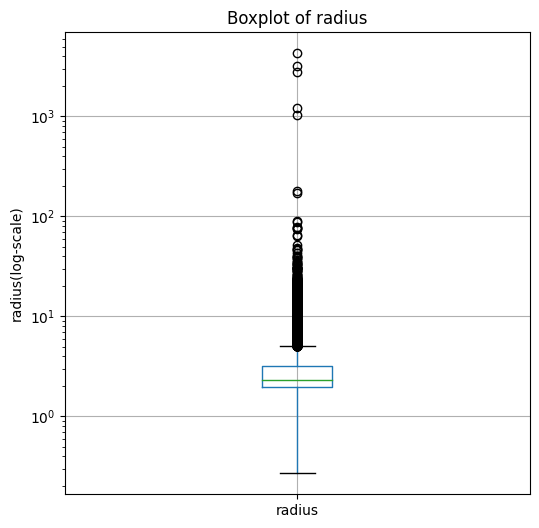

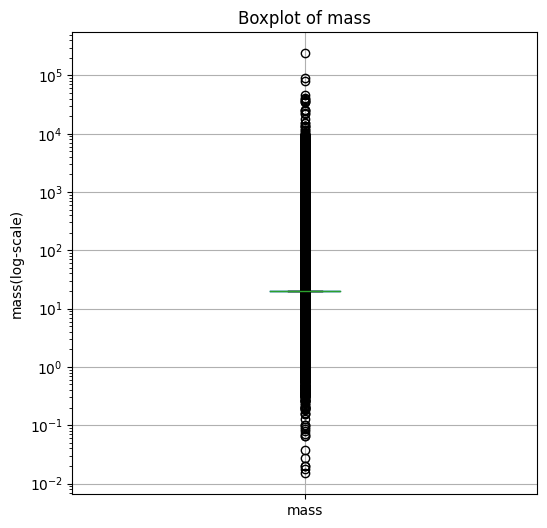

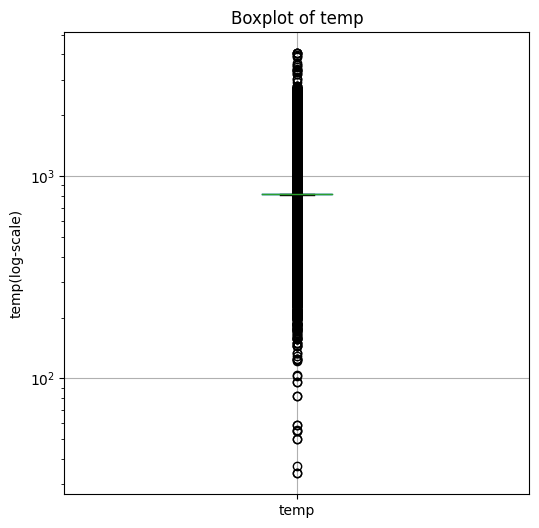

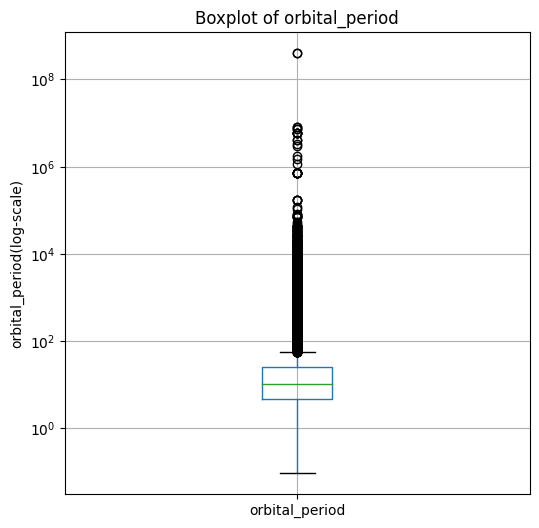

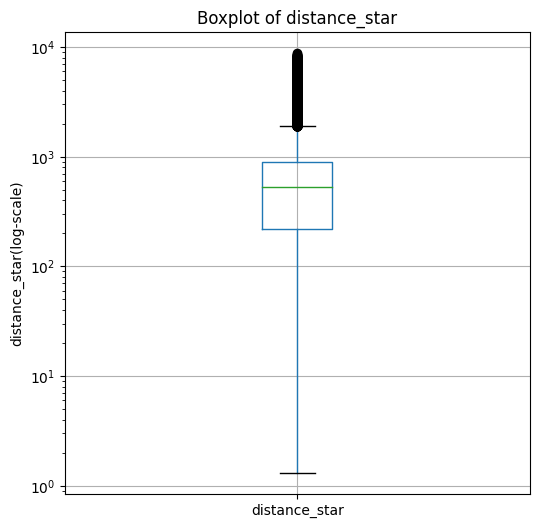

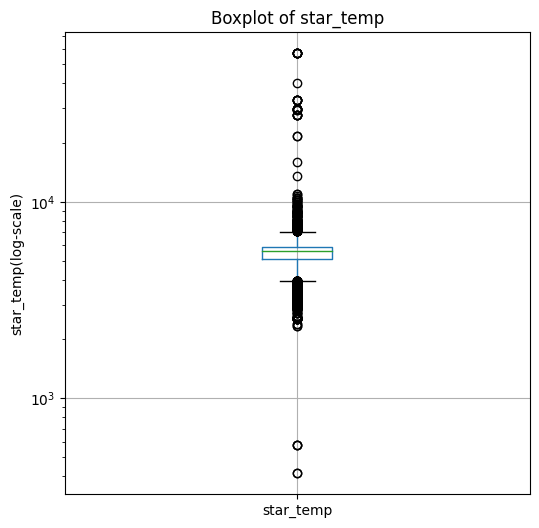

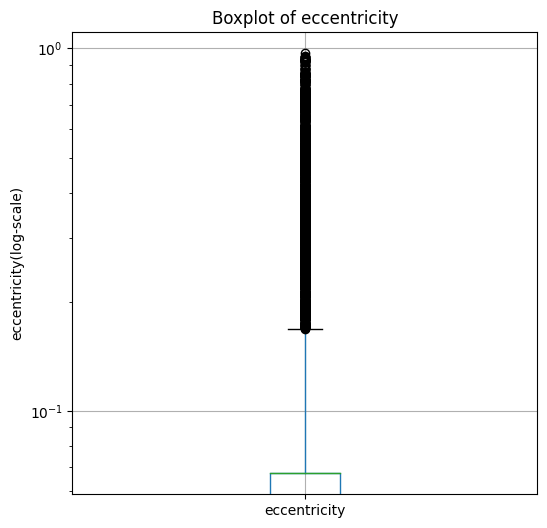

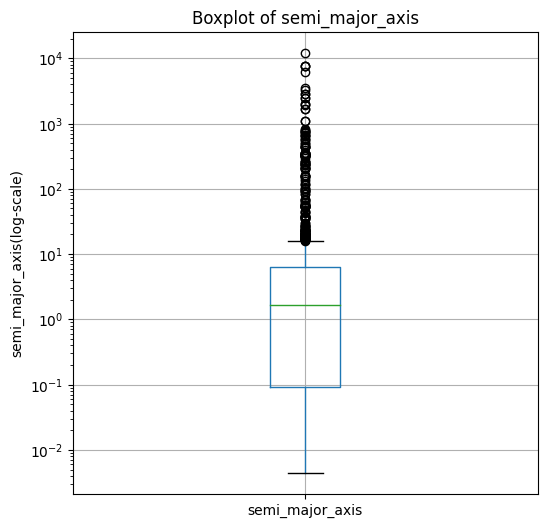

In [340]:
import matplotlib.pyplot as plt

numeric_cols = [
    "radius", "mass", "temp", "orbital_period",
    "distance_star", "star_temp", "eccentricity",
    "semi_major_axis"
]

for col in numeric_cols:
    plt.figure(figsize=(6,6))
    df_clean.boxplot(column=[col],vert=True)
    plt.yscale('log')
    plt.title(f"Boxplot of {col}")
    plt.ylabel(f"{col}(log-scale)")
    plt.show()

In [341]:
domain_limits = {
    "radius": (0.3, 30),          # Earth radii
    "mass": (0.1, 5000),          # Earth mass
    "temp": (30, 6000),           # Kelvin
    "orbital_period": (0.1, 5000),# days
    "distance_star": (0.01, 10000),# parsecs
    "star_temp": (2000, 15000),   # Kelvin
    "eccentricity": (0, 1),       # must be 0-1
    "semi_major_axis": (0.01, 50)
}# Setting domain limits acc to Physics knowledge

#SOft IQR with Winsorization(Cropping )
def cap_outliers_soft_iqr(df, col, multiplier=3.0):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    # Skip if no spread
    if IQR == 0:
        print(f"⚠️ Skipping {col}: IQR=0")
        return df

    lower_iqr = Q1 - multiplier * IQR
    upper_iqr = Q3 + multiplier * IQR

    print(f"\nCapping {col} using soft IQR ({multiplier}×IQR):")
    print(f"IQR-based limits: {lower_iqr} → {upper_iqr}")
    df[col] = df[col].clip(lower=lower_iqr, upper=upper_iqr)
    return df

df_final = df_clean.copy()

# Apply domain limits
for col, (low, high) in domain_limits.items():
    print(f"Capping {col} to domain [{low}, {high}]")
    df_final[col] = df_final[col].clip(lower=low, upper=high)

# Apply soft IQR winsorization
for col in domain_limits.keys():
    df_final = cap_outliers_soft_iqr(df_final, col, multiplier=3.0)

print("\nFinal dataset shape:", df_final.shape)

Capping radius to domain [0.3, 30]
Capping mass to domain [0.1, 5000]
Capping temp to domain [30, 6000]
Capping orbital_period to domain [0.1, 5000]
Capping distance_star to domain [0.01, 10000]
Capping star_temp to domain [2000, 15000]
Capping eccentricity to domain [0, 1]
Capping semi_major_axis to domain [0.01, 50]

Capping radius using soft IQR (3.0×IQR):
IQR-based limits: -1.6800000000000006 → 6.860000000000001
⚠️ Skipping mass: IQR=0

Capping temp using soft IQR (3.0×IQR):
IQR-based limits: 809.0 → 816.0

Capping orbital_period using soft IQR (3.0×IQR):
IQR-based limits: -57.398025999999994 → 87.32862599999999

Capping distance_star using soft IQR (3.0×IQR):
IQR-based limits: -1800.396 → 2907.111

Capping star_temp using soft IQR (3.0×IQR):
IQR-based limits: 2772.0 → 8225.0

Capping eccentricity using soft IQR (3.0×IQR):
IQR-based limits: -0.20164168316498318 → 0.2688555775533109

Capping semi_major_axis using soft IQR (3.0×IQR):
IQR-based limits: -18.933856130248934 → 25.4567748

In [342]:
for col in selected_cols:
    print(df_final[col].describe())

'''## 🔍 Outlier Detection Using Summary Statistics
### What we check:
- Minimum and maximum values  
- Median and quartiles  
- Domain validity (e.g., eccentricity must be 0–1, radius must be < 30 Earth radii)
'''

count    33290.000000
mean         3.051860
std          1.872536
min          0.300000
25%          1.980000
50%          2.330000
75%          3.200000
max          6.860000
Name: radius, dtype: float64
count    33290.000000
mean       197.220750
std        668.874908
min          0.100000
25%         19.800000
50%         19.800000
75%         19.800000
max       5000.000000
Name: mass, dtype: float64
count    33290.000000
mean       812.321804
std          2.431815
min        809.000000
25%        812.000000
50%        812.000000
75%        813.000000
max        816.000000
Name: temp, dtype: float64
count    33290.000000
mean        22.558175
std         27.510177
min          0.100000
25%          4.627682
50%         10.300679
75%         25.302918
max         87.328626
Name: orbital_period, dtype: float64
count    33290.000000
mean       638.524455
std        565.501825
min          1.301190
25%        217.107000
50%        527.321000
75%        889.608000
max       2907.111000


'## 🔍 Outlier Detection Using Summary Statistics\n### What we check:\n- Minimum and maximum values  \n- Median and quartiles  \n- Domain validity (e.g., eccentricity must be 0–1, radius must be < 30 Earth radii)\n'

In [343]:
#One hot Encoding
print("Before encoding:",df_final.shape)
df_encoded=pd.get_dummies(df_final,columns=['star_type'],prefix='star')
print("after encoding:",df_encoded.shape)
df_encoded.head()
df_encoded = df_encoded.loc[:, (df_encoded != 0).any(axis=0)]
print("Shape after cleanup:", df_encoded.shape)
df_ready=df_encoded.copy()

Before encoding: (33290, 9)
after encoding: (33290, 288)
Shape after cleanup: (33290, 288)


In [344]:
#verification of objectives of module 2 until now
df_ready.isnull().sum()
df_ready.describe()
df_ready.info()
'star_type' in df_ready.columns
[col for col in df_ready.columns if col.startswith('star_')][:10]

<class 'pandas.core.frame.DataFrame'>
Index: 33290 entries, 0 to 38823
Columns: 288 entries, radius to star_m3 V
dtypes: bool(280), float64(8)
memory usage: 11.2 MB


['star_temp',
 'star_A',
 'star_A0 V',
 'star_A1 IV-V',
 'star_A2',
 'star_A2 V',
 'star_A5',
 'star_A5 V',
 'star_A5-A6',
 'star_A7 V']

In [345]:
##Habitability score
df_hab=df_ready.copy()
def normalize(series):
    return(series-series.min())/(series.max()-series.min())

#Calculating the paramters for calculating habitability score
radius_score = 1 - normalize(abs(df_hab['radius'] - 1.5))
temp_score = 1 - normalize(abs(df_hab['temp'] - 288))
orbit_score = 1 - normalize(abs(df_hab['orbital_period'] - 365))
star_temp_score = 1 - normalize(abs(df_hab['star_temp'] - 5778))
ecc_score = 1 - normalize(df_hab['eccentricity'])
mass_score=1 - normalize(abs(df_hab['mass']-1))

df_hab['habitability_score'] = (
      0.18 * radius_score
    + 0.22 * temp_score
    + 0.12 * orbit_score
    + 0.22 * star_temp_score
    + 0.10 * ecc_score
    + 0.16 * mass_score     # NEW
)

df_hab['habitability_score'] = df_hab['habitability_score'].clip(0, 1)
df_hab[['radius','mass','temp','orbital_period','star_temp','eccentricity','habitability_score']].head()


,radius,mass,temp,orbital_period,star_temp,eccentricity,habitability_score
0,6.86,4914.898486,816.0,87.328626,4874.0,0.238000,0.288039
1,6.86,5000.000000,816.0,87.328626,4742.0,0.231000,0.278259
2,2.33,5000.000000,812.0,10.300679,5612.0,0.067214,0.574725
3,6.86,3337.070000,816.0,87.328626,4340.0,0.080000,0.358226
4,2.33,4684.814200,812.0,87.328626,4213.0,0.080000,0.583636


In [346]:
df_hab.columns

Index(['radius', 'mass', 'temp', 'orbital_period', 'distance_star',
       'star_temp', 'eccentricity', 'semi_major_axis', 'star_A', 'star_A0 V',
       ...
       'star_M7.25', 'star_M7.5', 'star_M8', 'star_M8.5', 'star_M9',
       'star_M9-L1', 'star_Unknown', 'star_WD', 'star_m3 V',
       'habitability_score'],
      dtype='object', length=289)

In [347]:
#calculating stellar compatibility index
df_sci = df_hab.copy()

# ---------------------------------------------------
# 1. Ensure metallicity exists
# ---------------------------------------------------
if 'st_metfe' not in df_sci.columns:
    df_sci['st_metfe'] = 0.0
else:
    df_sci['st_metfe'] = df_sci['st_metfe'].fillna(0)

# ---------------------------------------------------
# 2. Normalization helper
# ---------------------------------------------------
def safe_normalize(series):
    if series.max() == series.min():
        return pd.Series([0.5] * len(series))
    return (series - series.min()) / (series.max() - series.min())

# ---------------------------------------------------
# 3. Star Temp & Metallicity Scores
# ---------------------------------------------------
df_sci['star_temp_score'] = 1 - safe_normalize(abs(df_sci['star_temp'] - 5778))
df_sci['metallicity_score'] = safe_normalize(df_sci['st_metfe'])

# ---------------------------------------------------
# 4. Compute spectral score FROM one-hot encoded columns
# ---------------------------------------------------

# Initialize spectral score
df_sci['spectral_score'] = 0.0

# Weight mapping by star type groups(all the one hot encoded grps)
spectral_weights = {
    'star_G': 1.0,
    'star_K': 0.9,
    'star_M': 0.7,
    'star_F': 0.5,
    'star_A': 0.3,
    'star_B': 0.1,
    'star_O': 0.05,
    'star_W': 0.2,         # White dwarfs: low compatibility
    'star_Unknown': 0.2
}

# Apply weights
for prefix, weight in spectral_weights.items():
    cols = [c for c in df_sci.columns if c.startswith(prefix)]
    if cols:
        df_sci['spectral_score'] += df_sci[cols].sum(axis=1) * weight

# ---------------------------------------------------
# 5. Final SCI formula (weighted)
# ---------------------------------------------------
df_sci['stellar_compatibility_index'] = (
      0.45 * df_sci['star_temp_score']
    + 0.30 * df_sci['spectral_score']
    + 0.25 * df_sci['metallicity_score']
)

df_sci['stellar_compatibility_index'] = df_sci['stellar_compatibility_index'].clip(0, 1)

# 6. FIX: Recompute SCI for missing rows
# ---------------------------------------
DEFAULT_TEMP_SCORE = 0.5
DEFAULT_METAL_SCORE = 0.5
DEFAULT_SPEC_SCORE = 0.2

df_sci['star_temp_score'] = df_sci['star_temp_score'].fillna(DEFAULT_TEMP_SCORE)
df_sci['metallicity_score'] = df_sci['metallicity_score'].fillna(DEFAULT_METAL_SCORE)
df_sci['spectral_score'] = df_sci['spectral_score'].fillna(DEFAULT_SPEC_SCORE)
df_sci['stellar_compatibility_index'] = (
      0.45 * df_sci['star_temp_score']
    + 0.30 * df_sci['spectral_score']
    + 0.25 * df_sci['metallicity_score']
).clip(0, 1)

df_sci['stellar_compatibility_index'].isnull().sum()

# Preview
df_sci[['star_temp', 'st_metfe', 'spectral_score', 'stellar_compatibility_index']].head()

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)


,star_temp,st_metfe,spectral_score,stellar_compatibility_index
0,4874.0,0.0,1.0,0.739671
1,4742.0,0.0,1.0,0.719910
2,5612.0,0.0,0.2,0.610150
3,4340.0,0.0,0.9,0.629731
4,4213.0,0.0,0.2,0.400719


In [348]:
# Start with df_hab (contains habitability_score)
df_final_ml = df_hab.copy()

# Add SCI column from df_sci
df_final_ml['stellar_compatibility_index'] = df_sci['stellar_compatibility_index']

df_final_ml[['habitability_score', 'stellar_compatibility_index']].head()


,habitability_score,stellar_compatibility_index
0,0.288039,0.739671
1,0.278259,0.719910
2,0.574725,0.610150
3,0.358226,0.629731
4,0.583636,0.400719


In [349]:
df_final_ml.shape

(33290, 290)

In [350]:
#NORMALIZATION 
from sklearn.preprocessing import MinMaxScaler

# ---------------------------------------
# 1. COPY FINAL ML DATASET
# ---------------------------------------
df_scaled = df_final_ml.copy()

# ---------------------------------------
# 2. IDENTIFY NUMERICAL COLUMNS
# ---------------------------------------
numeric_cols = [
    'radius',
    'mass',
    'temp',
    'orbital_period',
    'distance_star',
    'star_temp',
    'eccentricity',
    'semi_major_axis',
    'habitability_score',
    'stellar_compatibility_index'
]

# ---------------------------------------
# 3. APPLY MIN-MAX SCALING
# ---------------------------------------
scaler = MinMaxScaler()

df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])

# ---------------------------------------
# 4. CHECK RESULTS to ensure all vlaues lie between 0 to 1
# ---------------------------------------
print("Shape after scaling:", df_scaled.shape)
print("\nSummary of scaled values:")
print(df_scaled[numeric_cols].describe())


Shape after scaling: (33290, 290)

Summary of scaled values:
             radius          mass          temp  orbital_period  \
count  33290.000000  33290.000000  33290.000000    33290.000000   
mean       0.419491      0.039425      0.474543        0.257463   
std        0.285448      0.133778      0.347402        0.315380   
min        0.000000      0.000000      0.000000        0.000000   
25%        0.256098      0.003940      0.428571        0.051906   
50%        0.309451      0.003940      0.428571        0.116942   
75%        0.442073      0.003940      0.571429        0.288929   
max        1.000000      1.000000      1.000000        1.000000   

       distance_star     star_temp  eccentricity  semi_major_axis  \
count   33290.000000  33290.000000  33290.000000     33290.000000   
mean        0.219293      0.487654      0.224255         0.128283   
std         0.194611      0.136846      0.232966         0.136396   
min         0.000000      0.000000      0.000000         0.

In [351]:
#Validation check 1--NULL values
print("🔍 Missing values:")
print(df_scaled.isnull().sum())

print("\n📊 Descriptive statistics:")
df_scaled.describe()


🔍 Missing values:
radius                         0
mass                           0
temp                           0
orbital_period                 0
distance_star                  0
                              ..
star_Unknown                   0
star_WD                        0
star_m3 V                      0
habitability_score             0
stellar_compatibility_index    0
Length: 290, dtype: int64

📊 Descriptive statistics:


,radius,mass,temp,orbital_period,distance_star,star_temp,eccentricity,semi_major_axis,habitability_score,stellar_compatibility_index
count,33290.000000,33290.000000,33290.000000,33290.000000,33290.000000,33290.000000,33290.000000,33290.000000,33290.000000,33290.000000
mean,0.419491,0.039425,0.474543,0.257463,0.219293,0.487654,0.224255,0.128283,0.654919,0.552167
std,0.285448,0.133778,0.347402,0.315380,0.194611,0.136846,0.232966,0.136396,0.140177,0.149079
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.256098,0.003940,0.428571,0.051906,0.074267,0.428571,0.000000,0.003171,0.584070,0.501280
50%,0.309451,0.003940,0.428571,0.116942,0.181023,0.520814,0.250000,0.064448,0.685393,0.586563
75%,0.442073,0.003940,0.571429,0.288929,0.305700,0.571429,0.250000,0.252378,0.734097,0.620850
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


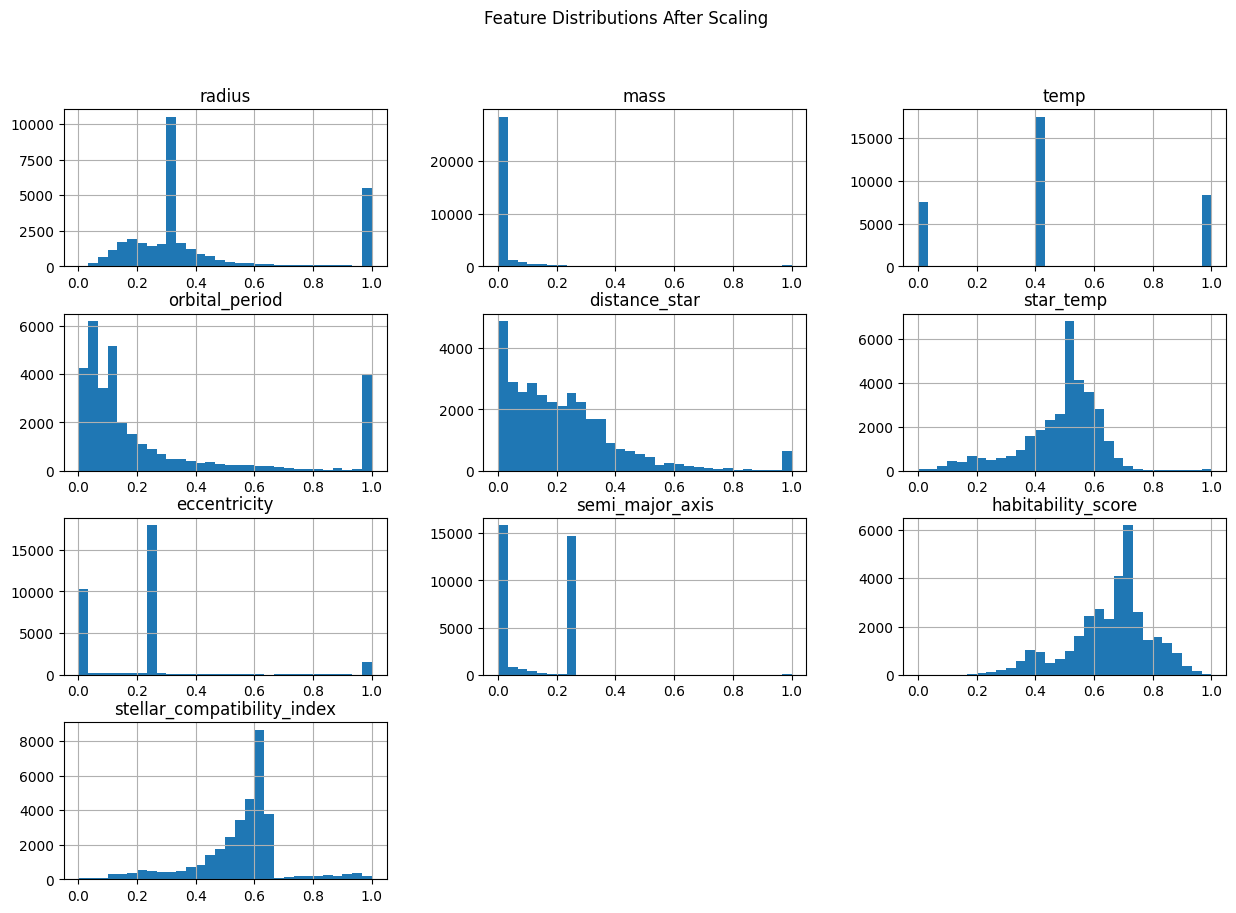

In [352]:
#VALIDATION WITH HISTOGRAM PLOTTING 
import matplotlib.pyplot as plt

df_scaled[numeric_cols].hist(figsize=(15, 10), bins=30)
plt.suptitle("Feature Distributions After Scaling") #suptitle is super title
plt.show()


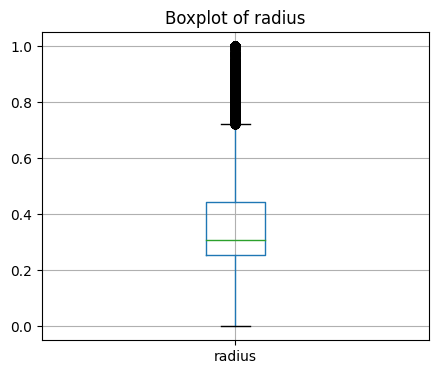

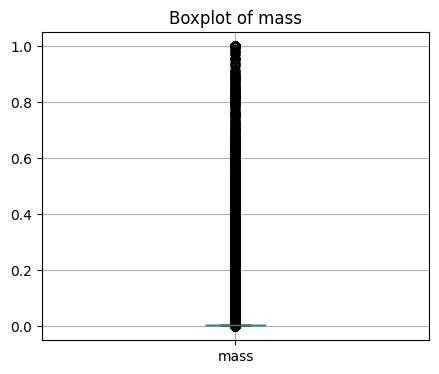

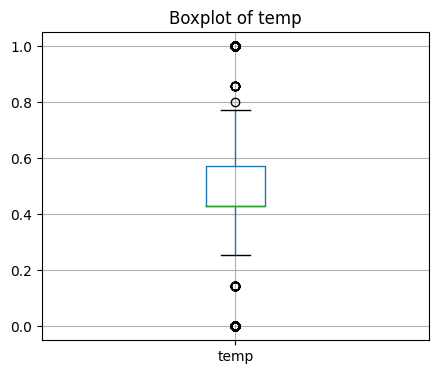

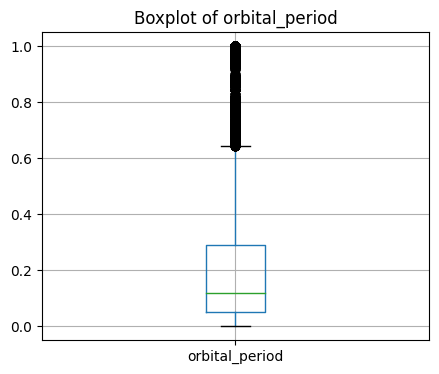

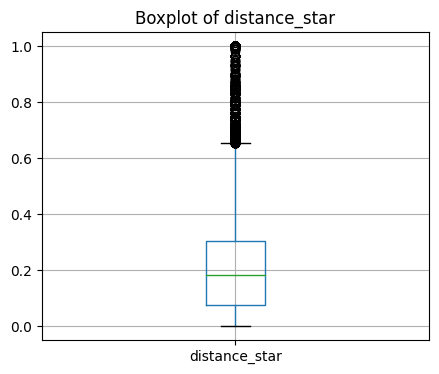

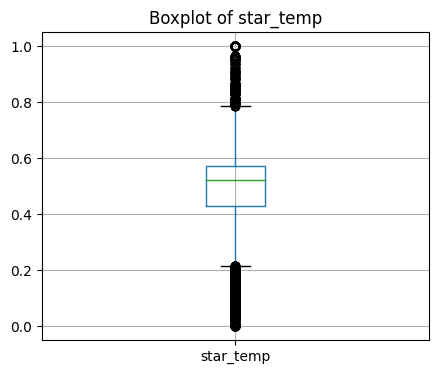

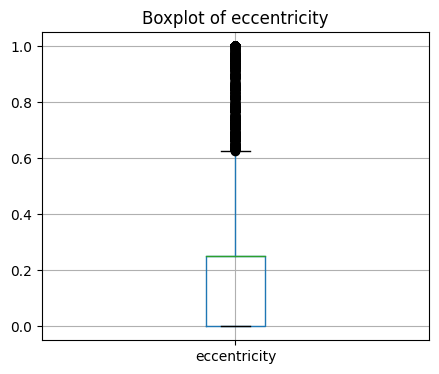

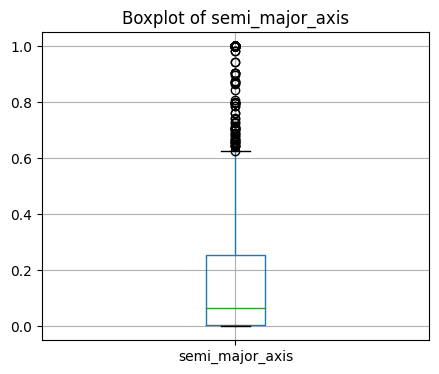

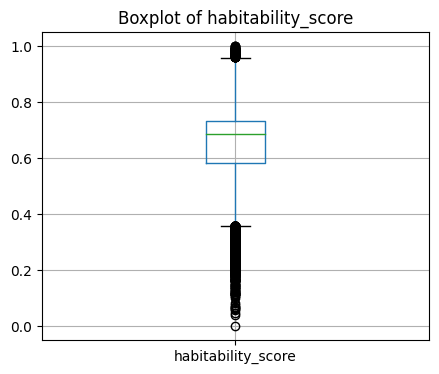

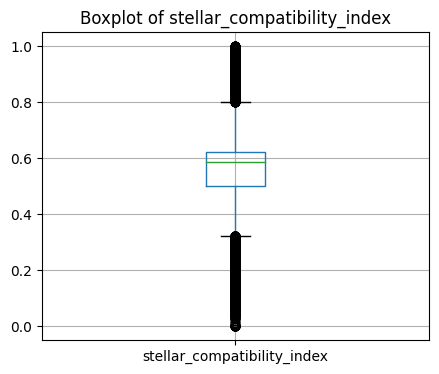

In [353]:
#VALIDATION 3 USING BOXPLOTS TO CHECK FOR OUTLIERS
for col in numeric_cols:
    plt.figure(figsize=(5,4))
    df_scaled.boxplot(column=[col])
    plt.title(f"Boxplot of {col}")
    plt.show()


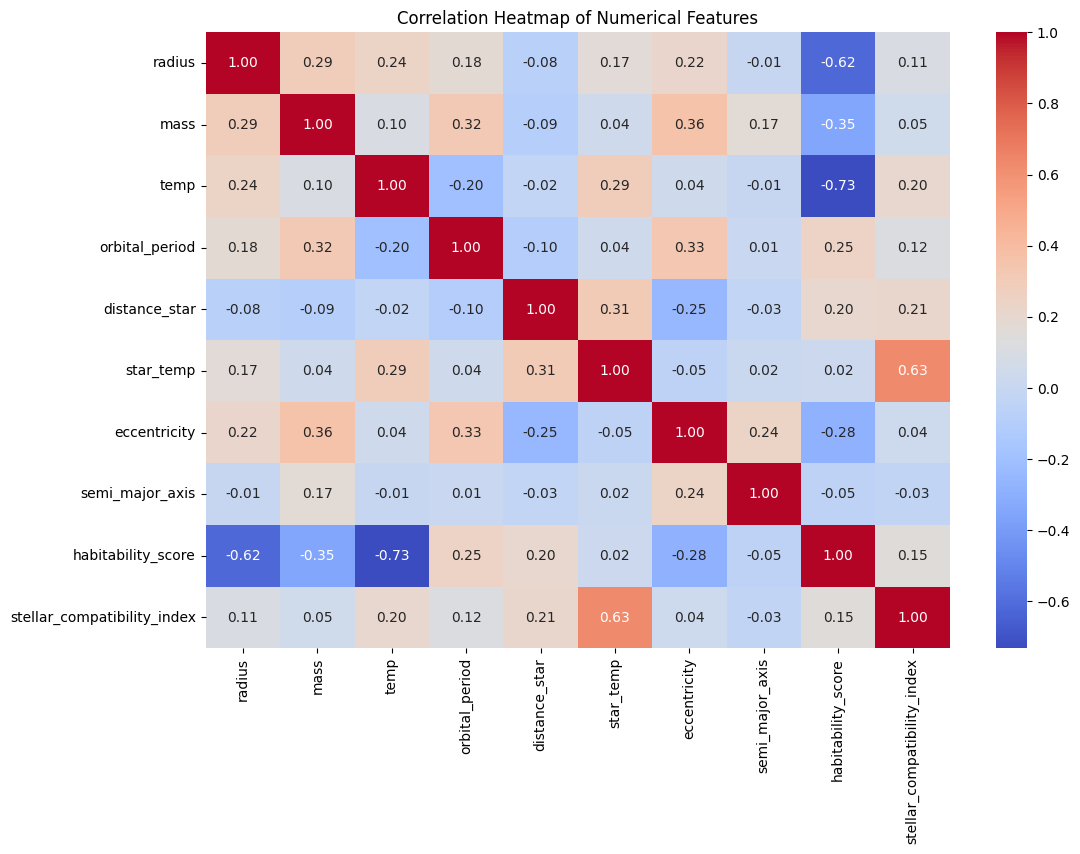

In [354]:
#HEATMAP OF FEATURES AS FINAL VALIDATION
import seaborn as sns
plt.figure(figsize=(12,8))

#heatmap plotting
sns.heatmap(df_scaled[numeric_cols].corr(),
            annot=True,
            cmap="coolwarm",
            fmt=".2f")

plt.title("Correlation Heatmap of Numerical Features")
plt.show()


In [355]:
df_scaled.shape
df_scaled.isnull().sum()

radius                         0
mass                           0
temp                           0
orbital_period                 0
distance_star                  0
                              ..
star_Unknown                   0
star_WD                        0
star_m3 V                      0
habitability_score             0
stellar_compatibility_index    0
Length: 290, dtype: int64